# Avazu CTR Prediction

### Model Summaries: The best ROC AUC Score for each model.

#### Best Logistic Regression: 0.6955

#### Best Gradient Boosting: 0.6955

### Best Xgboost: 0.7383

#### Best Random Forest: 0.7367

XGboost had the best perfomance among the models. 

todo-Comprehensive Plots of model performance, more cross validation and tweaking of cv for better results, add previous CTR as a feature, explore autocorrelation in model, use Mummify to track model changes(https://github.com/maxhumber/mummify)

## Examples of comprehensive model performance plots

![Model Comparison](https://scikit-learn.org/stable/_images/sphx_glr_plot_feature_transformation_002.png)

https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

![Roc Curve](https://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png)



https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

![Roc Curve-CV](https://scikit-learn.org/stable/_images/sphx_glr_plot_roc_crossval_001.png)


https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

### XGboost Notes

#### What is XGboost?

##### Extreme Gradient Boosting

Focused on **computational speed** and **model performance**: few frills, but a good amount of advanced features

##### Background Information


1) Original Creator was doing research on variants of tree boosting. He was looking to combine boosted trees with a conditional random field and found no existing model that satisfied his needs. 

2) Author states that you cannot be successful with XGboost alone, you need to process data, and feature engineer first. 

##### Model Features

3 forms of gradient boosting are supported:

1) **Gradient Boosting**- also called gradient boosting machine(w/ variable learning rate)

2) **Stochastic Gradient Boosting**- with subsampling at the row, column, and column per split levels

3) **Regularized Gradient Boosting**-with L1 and L2 regularization

##### System Features

1) **Parallelization** of tree-use all CPY cores during training

2) **Distributed Computing** for training large models on a cluster of machines

3) **Out of Core Computing** for large datasets that don't fit into memory

4) **Cache Optimization** of data structures and algorithms to make best use of hardware

##### Algorithm Features

1) **Sparse Aware** implementation with automatic handling of missing data values

2) **Block Structure** to support the parallelization of tree construction

3) **Continued Training** so that you can further boost an already fitted model on new data

#### Why use XGB

**Execution Speed** and **Model performance**

Very Fast, has been benchmarked against other models and performs well against the feild 

##### Model performance

XGB thrives with **structured or tabular datasets** on **classification** and **regression** predictive modeling problems

##### What algorithm does it use?

**Gradient Boosted Decision Tree**: boosting is an ensemble technique where new models are added to correct errors made by existing models. Models are added sequentially until no further improvements can be made

**Gradient Boosting** is an approach where new models are created that predict the residuals or errors of prior models then adds them back together to make a final predictions.

It’s called **gradient boosting** because it uses a gradient descent algorithm to minimize the loss when adding new models



## Bidding Strategy

If we combine the partial depencies that generate the most clicks, we should be able to create a bidding strategy that optimizes for clicks. Some features, such as the time or day jump out, but have to factor in the potential higher cost of buying ads when people are clicking as well. If all ads cost the same regardless of time or device, we could simply find the highest click through rate for each feature and optimizee a model to those parameters.

todo-expand on this idea and plot all the partial dependencies. Explore relationship between dependencies. Get an average cost for ads depending on features.

## Imports

### Import Libraries

In [222]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sklearn
import matplotlib.dates as mdates
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder

### Ignore Warnings

In [223]:
'''Ignore Warning Messages'''
import warnings
warnings.filterwarnings('ignore')

### Matplotlib Style

In [224]:
'''Set style to GGplot for asthetics'''
matplotlib.style.use('ggplot')


### Sample and Import Dataset

In [225]:
''' Sample from Training Data down to 1 million records'''

n = 40428966  #total number of records in the dataset 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random

In [226]:
df = pd.read_csv('train.csv', skiprows = skip_values)

## Data Prepation

### Date Time conversion with Hour feature

In [227]:
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

### Create weekday and datetime from hour

In [228]:
df['weekday'] = df['hour'].apply(lambda x : datesplit(x).weekday()) 

In [229]:
df['hour'] = df['hour'].apply(lambda x : datesplit(x).hour)

### Vizualizations

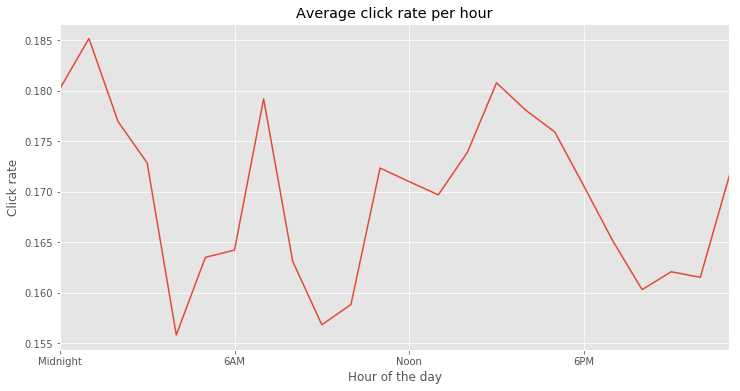

In [230]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['hour'])['click'].mean())
plt.xlabel("Hour of the day")
plt.ylabel("Click rate")
plt.title("Average click rate per hour")
plt.xticks(np.arange(0, 23, step=6), ('Midnight', '6AM', 'Noon', '6PM'))
plt.xlim([0.0, 23.0])
plt.show()

Users click on ads the most around 1 AM, 7AM, and 3PM.
They click on ads the least around 4AM, 9AM, and 8 PM.

This suggests that the best time to run ads for maximum impressions is just after midnight, but not too late, early in the morning but before the work commute begins, and in the afternoon. This maps well with when workers are least prodcutive at work, the afternoon. During the evening users may be engaging in activities outside of a screen, but later at night they are back on the internet.

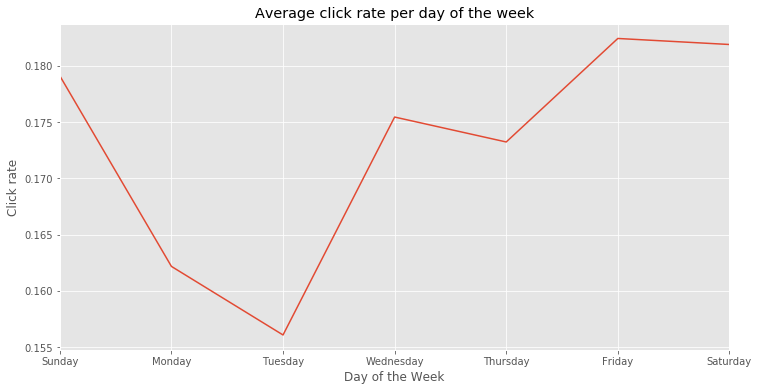

In [231]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['weekday'])['click'].mean())
plt.xlabel("Day of the Week")
plt.xticks(np.arange(0, 7, step=1), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',))
plt.xlim([0.0, 6.0])
plt.ylabel("Click rate")
plt.title("Average click rate per day of the week")
plt.show()

Users click on ads the most on the weekend, which suggests that when users have free time, they are spending it online. Tuesday and Monday are the worst days for ads, and as we get closer to the weekend, click rates improve.

### Variable Encoding

In [232]:
model_features = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

In [233]:
model_target = 'click'

In [234]:
train_model = df[model_features+[model_target]]

In [235]:
train_model = df[model_features+[model_target]]

In [236]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [237]:
train_model = one_hot_features(train_model, ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'])

In [238]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [239]:
X = train_model[model_features].values

In [240]:
y = train_model[model_target].values

### Test Train Splt

In [241]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1,
                                                 random_state=100)

## Modeling

### Linear Regression

In [242]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [243]:
hard = lr.predict(Xtest)
soft = lr.predict_proba(Xtest)

In [244]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

#### Plot the roc curve

In [245]:
from sklearn.metrics import roc_auc_score
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.677697459257791


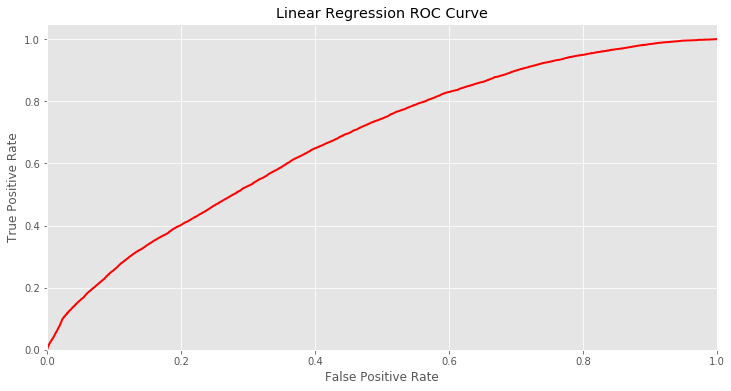

In [246]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Regression ROC Curve')
plt.show()

### Confusion Matrix

In [247]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [248]:
from sklearn import metrics

print(confusion_matrix(ytest, predictions))

[[83020    87]
 [16754   140]]


### Add site and user

In [249]:
values = df['device_id'].value_counts().idxmax() 

df['user'] = np.where(df['device_id'] == values, df['device_ip'] + df['device_model'], df['device_id']) 

In [250]:
df = df.drop(['device_id', 'device_model', 'device_ip'], axis=1) 


In [251]:
df['site'] = df['site_id'] + df['site_domain'] 


In [252]:
df = df.drop(['site_id', 'site_domain'], axis=1)


### Create another test train split

In [253]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

In [254]:
n_ones = np.array(Xtrain.sum(axis=0))


In [255]:
useful = n_ones > 100 


In [256]:
import collections
collections.Counter(useful)

Counter({True: 148, False: 34})

In [257]:
cols_to_keep = [i*b for i,b in enumerate(useful) if b == True]


In [258]:
Xtrain = Xtrain[:,cols_to_keep] 

In [259]:
Xtest = Xtest[:,cols_to_keep]


### Gradient Boosting

In [265]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8, verbose=True) 
gb.fit(Xtrain, ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8723            2.29m
         2           0.8630            2.50m
         3           0.8594            2.32m
         4           0.8578            2.14m
         5           0.8552            2.12m
         6           0.8537            2.01m
         7           0.8527            1.90m
         8           0.8507            1.82m
         9           0.8500            1.72m
        10           0.8478            1.68m
        20           0.8410            1.23m
        30           0.8389           47.31s
        40           0.8363           23.58s
        50           0.8349            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False)

In [266]:
soft = gb.predict_proba(Xtest)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.697080438973394


In [267]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[165889    179]
 [ 33631    302]]


In [271]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8, verbose=False,) 
gb.fit(Xtrain, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0,
              verbose=False, warm_start=False)

In [272]:
soft = gb.predict_proba(Xtest)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.6970920180067104


### Create leaves from gradient boosting

In [273]:
leaves_train = gb.apply(Xtrain)[:,:,0] 
leaves_test = gb.apply(Xtest)[:,:,0] 

In [274]:
leaves_train = pd.DataFrame(leaves_train) 
leaves_test = pd.DataFrame(leaves_test)

### Encoding

In [275]:
encoder = OneHotEncoder(handle_unknown = 'ignore') 
leaves_train_encoded = encoder.fit_transform(leaves_train)
leaves_test_encoded = encoder.transform(leaves_test)

In [276]:
from scipy.sparse import csr_matrix, hstack
Xtrain_hstack = hstack([ Xtrain, leaves_train_encoded]) 

In [277]:
Xtest_hstack = hstack([ Xtest, leaves_test_encoded])

### Logistic Regression on new data

In [278]:
lr = LogisticRegression()
lr.fit(Xtrain_hstack, ytrain)
lr.predict(Xtest_hstack)
soft = gb.predict_proba(Xtest)
roc_auc_score(ytest, soft[:,1])

0.6970920180067104

### XGBoost

In [280]:
#!pip install xgboost-for first time running
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 50,n_jobs = -1,learning_rate = 0.8)
xgb.fit(Xtrain_hstack, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [281]:
xgb.predict(Xtrain_hstack)
soft = xgb.predict_proba(Xtest_hstack)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.6999213446825477


In [282]:
y_pred = xgb.predict(Xtest_hstack)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[165051   1017]
 [ 32534   1399]]


## Hashing

### Create new test train split

In [283]:
X = df.drop(['click'], axis=1)
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

### Hashing Function

In [284]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        
        for i in range(len(self.col_names)):
            serie = X[self.col_names[i]].value_counts()  # Series of each column
            rare_indexes = serie[serie<self.threshold[i]].index  # The indexes for least frequent features
            frequent_indexes = serie[serie>=self.threshold[i]].index  # The indexes for most frequent features
            dictionary = {x:'isRare' for x in rare_indexes}
            dictionary.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dictionary)   # Index for rare and most frequent
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
                
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
        # Represent the new features never observed and apply the count_dict to ther rest

        return Xt

In [285]:
merged = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_merged = merged.fit_transform(Xtrain)
Xtest_merged = merged.transform(Xtest)

### Test Hash

In [286]:
import hashlib
hash('test hash') 

8619595631211765194

### Hash the Dataframe

In [291]:
Xtrain_hashed = pd.DataFrame()
Xtest_hashed = pd.DataFrame()
for col in Xtrain_merged.columns:
    Xtrain_hashed[col] = Xtrain_merged[col].apply(lambda x : hash(str(x)) % 1000000) 
    Xtest_hashed[col] = Xtest_merged[col].apply(lambda x : hash( str(x)) % 1000000)

### Log of hashed vs original feature dimentionality

In [292]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [293]:
display(Xtrain.nunique()) 

display(Xtrain_hashed.nunique())

id                  800000
hour                    24
C1                       7
banner_pos               7
site_category           21
app_id                2920
app_domain             186
app_category            26
device_type              5
device_conn_type         4
C14                   2202
C15                      8
C16                      9
C17                    421
C18                      4
C19                     65
C20                    166
C21                     60
weekday                  7
user                632915
site                  5223
dtype: int64

id                     1
hour                  24
C1                     7
banner_pos             7
site_category         19
app_id               573
app_domain            51
app_category          19
device_type            5
device_conn_type       4
C14                 1315
C15                    8
C16                    9
C17                  380
C18                    4
C19                   64
C20                  143
C21                   60
weekday                7
user                 734
site                 808
dtype: int64

### Random Forests

In [294]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1024, min_samples_leaf = 20, verbose = False, n_jobs = -1)
rf.fit(Xtrain_hashed, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1024, n_jobs=-1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [295]:
soft = rf.predict_proba(Xtest_hashed)


In [296]:
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.7379152180213504


In [297]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, soft[:,1])

In [298]:
y_pred = rf.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[164751   1317]
 [ 31851   2082]]


In [299]:
random_forest_report = print(str(classification_report(ytest, predictions)))

             precision    recall  f1-score   support

          0       0.84      0.99      0.91    166068
          1       0.61      0.06      0.11     33933

avg / total       0.80      0.83      0.77    200001



### XGboost

In [ ]:
xgb = XGBClassifier(n_estimators = 1024,n_jobs = -1,learning_rate = 1)
xgb.fit(Xtrain_hashed, ytrain) 
soft = xgb.predict_proba(Xtest_hashed)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
y_pred = xgb.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

In [ ]:
xgboost_report = print(str(classification_report(ytest, predictions)))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost ROC Curve')
plt.show()

In [ ]:
xgb = XGBClassifier(n_estimators = 1000, n_jobs = -1,learning_rate = .5, min_child_weight= 100, monotone_constraints='(0)')
xgb.fit(Xtrain_hashed, ytrain) 
soft = xgb.predict_proba(Xtest_hashed)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [130]:
print(str(classification_report(ytest, predictions)))

             precision    recall  f1-score   support

          0       0.84      0.99      0.91    166089
          1       0.57      0.04      0.08     33912

avg / total       0.79      0.83      0.77    200001



### Cross validation-best cv

In [90]:
d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
d_valid = xgb.DMatrix(Xtest_hashed, ytest)

In [106]:
# XGBoost parameters 1
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'eval_metric': 'auc'
}



In [140]:
# Without early stopping, overfit model
bst_cv = xgb.cv(params, d_train, num_boost_round=10000, nfold=10, verbose_eval=100,  early_stopping_rounds=None, as_pandas=True)
    

[0]	train-auc:0.672185+0.00105952	test-auc:0.671635+0.00275147
[100]	train-auc:0.762093+0.00058721	test-auc:0.729699+0.00262078
[200]	train-auc:0.777474+0.00043057	test-auc:0.726112+0.00297126
[300]	train-auc:0.7881+0.000473304	test-auc:0.722606+0.00285694
[400]	train-auc:0.796906+0.000327834	test-auc:0.719385+0.00251505
[500]	train-auc:0.80401+0.000316801	test-auc:0.716457+0.00228233
[600]	train-auc:0.810056+0.000360432	test-auc:0.714268+0.00204106
[700]	train-auc:0.815336+0.000338319	test-auc:0.71232+0.00202072
[800]	train-auc:0.820206+0.000346611	test-auc:0.710391+0.00223985
[900]	train-auc:0.824496+0.000343541	test-auc:0.708623+0.00227715
[1000]	train-auc:0.828391+0.000380154	test-auc:0.706804+0.00233694
[1100]	train-auc:0.83199+0.000316294	test-auc:0.70516+0.00247026
[1200]	train-auc:0.83533+0.000404143	test-auc:0.70395+0.00257145
[1300]	train-auc:0.838397+0.000326448	test-auc:0.702894+0.00247952
[1400]	train-auc:0.841163+0.000344217	test-auc:0.701626+0.0024417
[1500]	train-auc:0.

In [141]:
bst_cv.tail()

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
9995,0.667383,0.002067,0.904816,0.000140
9996,0.667380,0.002062,0.904817,0.000139
9997,0.667374,0.002060,0.904819,0.000141
9998,0.667367,0.002059,0.904822,0.000142
9999,0.667361,0.002054,0.904823,0.000143


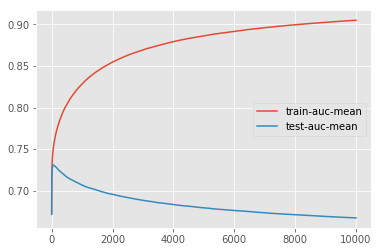

In [142]:
bst_cv[['train-auc-mean', 'test-auc-mean']].plot();

In [143]:
print(bst.eval(d_valid))

[0]	eval-auc:0.732289


In [107]:
# With early stopping. Use CV to find the best number of trees

bst_cv = xgb.cv(params, d_train, num_boost_round=1000, nfold=5, verbose_eval=100, early_stopping_rounds=10, as_pandas=True, )

[0]	train-auc:0.677451+0.00066328	test-auc:0.676628+0.00180714


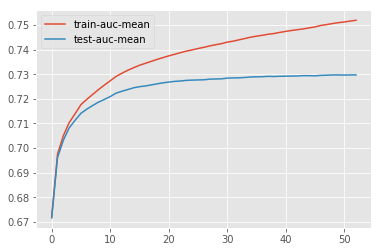

In [115]:
bst_cv[['train-auc-mean', 'test-auc-mean']].plot();

In [108]:
bst = xgb.train(params, d_train, num_boost_round=60)


In [109]:
print(bst.eval(d_valid))

[0]	eval-auc:0.729860


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def partial_dependency(bst, X, y, feature):
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(start=np.percentile(X_temp[feature], 0.1),
                       stop=np.percentile(X_temp[feature], 99.5),
                       num=50)
    
    y_pred = np.zeros(len(grid))

    for i, value in enumerate(grid):
        X_temp[feature] = value
        data = xgb.DMatrix(X_temp)
        y_pred[i] = np.average(bst.predict(data, ntree_limit=bst.best_ntree_limit))

    plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
    plt.plot(X, y, 'o', color='grey', alpha=0.01)
    plt.xlim(min(grid), max(grid))
    plt.xlabel(feature)
    plt.ylabel(y.name)
    plt.show()


In [97]:
features = list(Xtrain_hashed)

1


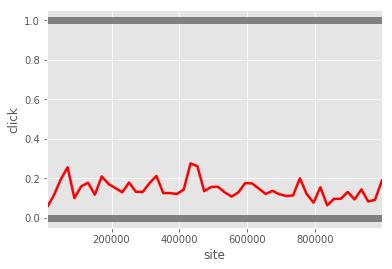

In [98]:
print(params['learning_rate'])

partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='site')

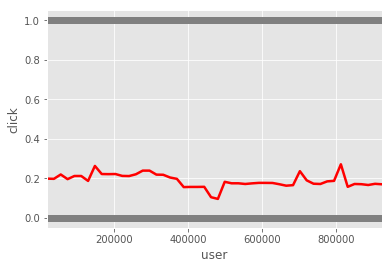

In [134]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='user')

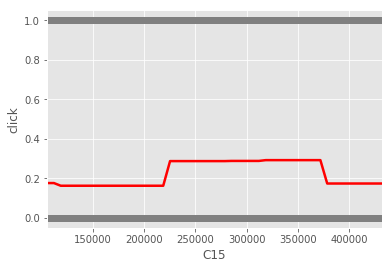

In [135]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='C15')

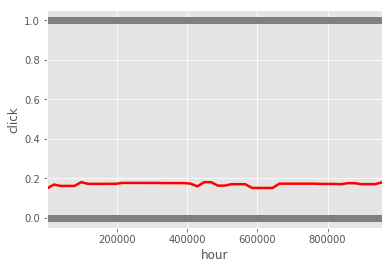

In [137]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='hour')

In [ ]:
todo-plot all the partial dependencies for bidding strategy

## Work in progress- K Folds

In [86]:
kfold = 2
skf = StratifiedKFold(n_splits=kfold, random_state=65)

In [92]:
# XGBoost parameters
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [93]:
models_by_fold = []

In [83]:
#Kfold 1

from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

[0]	train-auc:0.649499	test-auc:0.650687
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 150 rounds.
[100]	train-auc:0.702714	test-auc:0.703281
[200]	train-auc:0.711897	test-auc:0.712006
[300]	train-auc:0.718246	test-auc:0.717931
[400]	train-auc:0.722447	test-auc:0.721523
[500]	train-auc:0.725956	test-auc:0.724632
[600]	train-auc:0.72859	test-auc:0.726952
[700]	train-auc:0.730838	test-auc:0.72886
[800]	train-auc:0.732783	test-auc:0.730476
[900]	train-auc:0.734434	test-auc:0.731837
[1000]	train-auc:0.735766	test-auc:0.732853
[1100]	train-auc:0.737077	test-auc:0.733822
[1200]	train-auc:0.738228	test-auc:0.734684
[1300]	train-auc:0.739227	test-auc:0.735396
[1400]	train-auc:0.740214	test-auc:0.736134
[1500]	train-auc:0.741035	test-auc:0.736719
[1599]	train-auc:0.741813	test-auc:0.737225
[0]	train-auc:0.649499	test-auc:0.650687
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

In [95]:
#kfold2

from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

[0]	train-auc:0.649499	test-auc:0.650687
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 150 rounds.
[100]	train-auc:0.702714	test-auc:0.703281
[200]	train-auc:0.711897	test-auc:0.712006
[300]	train-auc:0.718246	test-auc:0.717931
[400]	train-auc:0.722447	test-auc:0.721523
[500]	train-auc:0.725956	test-auc:0.724632
[600]	train-auc:0.72859	test-auc:0.726952
[700]	train-auc:0.730838	test-auc:0.72886
[800]	train-auc:0.732783	test-auc:0.730476
[900]	train-auc:0.734434	test-auc:0.731837
[1000]	train-auc:0.735766	test-auc:0.732853
[1100]	train-auc:0.737077	test-auc:0.733822
[1200]	train-auc:0.738228	test-auc:0.734684
[1300]	train-auc:0.739227	test-auc:0.735396
[1400]	train-auc:0.740214	test-auc:0.736134
[1500]	train-auc:0.741035	test-auc:0.736719
[1600]	train-auc:0.74183	test-auc:0.737234
[1700]	train-auc:0.742625	test-auc:0.73775
[1800]	train-auc:0.743299	test-auc:0.738159
[1900]	train-auc:0.743972	test-auc:0.7

In [86]:
# XGBoost parameters 2
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [87]:
models_by_fold = []

In [97]:
#kfold 3
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

[0]	train-auc:0.649499	test-auc:0.650687
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 150 rounds.
[100]	train-auc:0.702714	test-auc:0.703281
[200]	train-auc:0.711897	test-auc:0.712006
[300]	train-auc:0.718246	test-auc:0.717931
[400]	train-auc:0.722447	test-auc:0.721523
[500]	train-auc:0.725956	test-auc:0.724632
[600]	train-auc:0.72859	test-auc:0.726952
[700]	train-auc:0.730838	test-auc:0.72886
[800]	train-auc:0.732783	test-auc:0.730476
[900]	train-auc:0.734434	test-auc:0.731837
[1000]	train-auc:0.735766	test-auc:0.732853
[1100]	train-auc:0.737077	test-auc:0.733822
[1200]	train-auc:0.738228	test-auc:0.734684
[1300]	train-auc:0.739227	test-auc:0.735396
[1400]	train-auc:0.740214	test-auc:0.736134
[1500]	train-auc:0.741035	test-auc:0.736719
[1599]	train-auc:0.741813	test-auc:0.737225
[0]	train-auc:0.649499	test-auc:0.650687
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

In [ ]:
#kfold 4
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

In [99]:
# XGBoost parameters 2
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'eval_metric': 'auc'
}

In [100]:
models_by_fold = []

In [101]:
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

[0]	train-auc:0.671866	test-auc:0.673262
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 150 rounds.
[100]	train-auc:0.760513	test-auc:0.731713
[200]	train-auc:0.774935	test-auc:0.728487
Stopping. Best iteration:
[77]	train-auc:0.756333	test-auc:0.732838

[0]	train-auc:0.671866	test-auc:0.673262
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 150 rounds.
[100]	train-auc:0.760513	test-auc:0.731713
[200]	train-auc:0.774935	test-auc:0.728487
Stopping. Best iteration:
[77]	train-auc:0.756333	test-auc:0.732838



In [ ]:
n_folds = 5
early_stopping = 10
params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}

xg_train = xgb.DMatrix(Xtrain_hashed, label=y_train);

cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

## Work in progess-K folds

In [ ]:
K = 5
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [ ]:
for train_index, test_index in kf.split(train):
    train_X, valid_X = train[train_index], train[test_index]
    train_y, valid_y = target_train[train_index], target_train[test_index]

    xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}

    d_train = xgb.DMatrix(train_X, train_y)
    d_valid = xgb.DMatrix(valid_X, valid_y)
    d_test = xgb.DMatrix(test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 5000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)
                        
    xgb_pred = model.predict(d_test)
    xgb_preds.append(list(xgb_pred))